In [7]:
import numpy as np 
import pandas as pd
import os
import glob
import re
import sys

import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import plotly.express as px
import folium
from folium import plugins
import branca
import json

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio
pio.renderers.default = "svg"

In [3]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset/", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])
data

['TimeAge',
 'SearchTrend',
 'TimeProvince',
 'Weather',
 'PatientRoute',
 'PatientInfo',
 'Region',
 'TimeGender',
 'Case',
 'Time']

# animated 확진자 경로

경로의 색깔 : 확진자가 접촉한 사람 수에 따라서

접촉자 0 명 : 초록색

접촉자 1~10 명 : 파란색

접촉자 11~100명 : 노란색

접촉자 100 초과 : 빨간색

접촉자 수가 최다인 사람 : 검정색

In [4]:
contnum = PatientInfo.iloc[:,[0,12]]
clr = []
for i in range(len(contnum)) :
    if contnum.contact_number[i] == 0 :
        clr.append("green")
    elif contnum.contact_number[i] <= 10 :
        clr.append("blue")
    elif contnum.contact_number[i] <= 100 :
        clr.append("yellow")
    elif contnum.contact_number[i] == max(contnum.contact_number) :
        clr.append("black")
    else : 
        clr.append("red")
contnum["color"] = clr
wcontnum = pd.merge(PatientRoute,contnum,
        how ='left',
        on = 'patient_id').fillna(0)
route_geo = gpd.GeoDataFrame(wcontnum,geometry=gpd.points_from_xy(PatientRoute.longitude,PatientRoute.latitude))

In [5]:
linerange = route_geo[route_geo['patient_id'] == route_geo['patient_id'].shift(1)].index
linerange = linerange.drop(linerange[-1])
lines = [ {
                "coordinates": [
                 [route_geo["longitude"][i] , route_geo["latitude"][i] ],
                 [route_geo["longitude"][i+1] , route_geo["latitude"][i+1],]
                   ],
                "dates": [
                 route_geo["date"][i],
                 route_geo["date"][i+1]
                   ],
                "color": route_geo["color"][i]
                     } for i in linerange ] 
features = [
     {
         'type': 'Feature',
         'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
                },
         'properties': {
            'times': line['dates'],
            'style': {
                'color' : line['color']
            },
            'icon' : 'circle',
            'iconstyle':{
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 3
                }
                }
        }
        for line in lines
    ]

In [8]:
m = folium.Map(
  location=[36.5053542,127.7043419],
  zoom_start=8
)
plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT6H', add_last_point=True).add_to(m)
m.save('with_color.html')
m

# 시간에 따른 infection case 별 누적 확진자 수

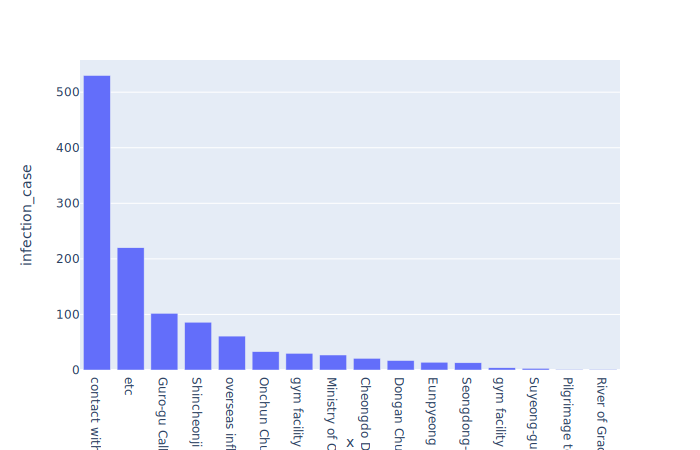

In [9]:
inf_count = pd.DataFrame(PatientInfo.infection_case.value_counts())
fig_0 = px.bar(inf_count,x=inf_count.index, y='infection_case')
fig_0.show()

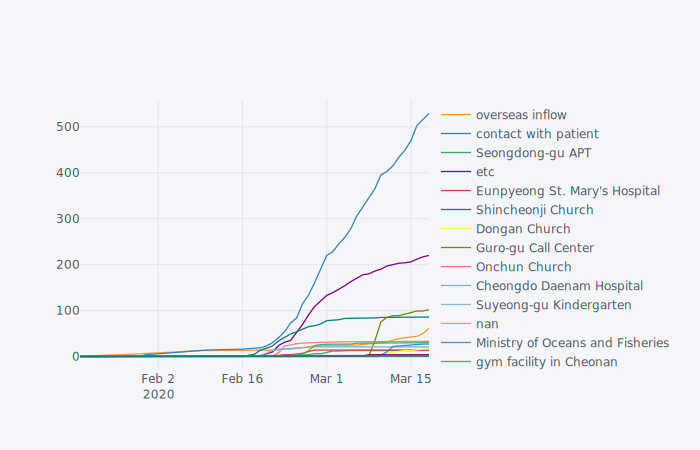

In [10]:
inf_case = PatientInfo.infection_case.unique()
for i in range(len(inf_case)) :
    globals()['case'+ str(i)] = PatientInfo[PatientInfo.infection_case == inf_case[i]]
    globals()['case'+str(i)] = pd.DataFrame(globals()['case'+ str(i)].groupby('confirmed_date').count().cumsum().patient_id).reset_index()
    globals()['case'+str(i)].columns = ['confirmed_date','case'+str(i)]   

merged = case0
for i in [x for x in range(len(inf_case)) if x != 0] :
    merged = pd.merge(merged , globals()['case'+str(i)],how= 'outer',on='confirmed_date')
merged = merged.sort_values(by = 'confirmed_date').reset_index()
merged = merged.drop('index',axis=1)
merged.columns = np.insert(inf_case,0,'confirmed_date')
merged = merged.fillna(method='pad')
merged = merged.fillna(0)
merged = merged.set_index('confirmed_date')
fig = merged.iplot(asFigure=True, kind='scatter')
fig.show()

overseas inflow 의 끝부분이 심상치않다